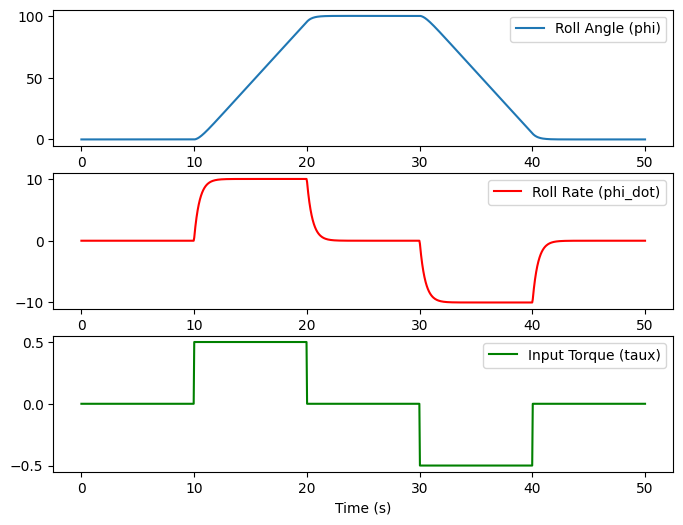

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the roll dynamics model
def roll_dynamics(y, t, Jx, c, t_vals, taux_vals):
    phi, phi_dot = y  # Unpack state variables
    
    # Interpolate the input torque at time t
    taux = np.interp(t, t_vals, taux_vals)
    
    # Define the system of equations
    phi_dot_dot = - (c / Jx) * phi_dot + (taux / Jx)
    
    return [phi_dot, phi_dot_dot]

# Define system parameters
Jx = 0.024  # Inertia around x-axis
c = 0.05    # Drag coefficient

# Define time span
t = np.linspace(0, 50, 1000)  # Simulating for 50 seconds

# Define piecewise constant torque input
taux_vals = np.piecewise(t, [t < 10, (10 <= t) & (t < 20), (20 <= t) & (t < 30), (30 <= t) & (t < 40), t >= 40],
                         [0, 0.5, 0, -0.5, 0])
t_vals = t  # Define the same time vector for interpolation

# Define initial conditions
y0 = [0, 0]  # Initial phi and phi_dot

# Solve the ODE
solution = odeint(roll_dynamics, y0, t, args=(Jx, c, t_vals, taux_vals))

# Extract solutions
phi = solution[:, 0]
phi_dot = solution[:, 1]

# Plot results
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.plot(t, phi, label="Roll Angle (phi)")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t, phi_dot, label="Roll Rate (phi_dot)", color='r')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t, taux_vals, label="Input Torque (taux)", color='g')
plt.legend()
plt.xlabel("Time (s)")
plt.show()


In [9]:
# Now let's compute system identification for the roll dynamics, given the input torque and the roll angle
# We will use the least squares method to fit the model parameters

# Define the least squares cost function by using an ARX model - Note: to tun this function, run the previous cells first
def LinearRegression(y, t, Jx, t_vals, c, taux):

    [phi_dot_label, rolldotdot_label] = roll_dynamics(y, t, Jx, t_vals, c, taux)

    # Dfinition of the ARX model, which is a linear combination of the autoregressive part and the input part
    # So now we get the optimal weights for the autoregressive part and the input part
    X = [phi_dot_label, taux]
    X = np.array(X).T
    optimal_weights = np.linalg.inv(X.T @ X) @ X.T @ rolldotdot_label

    # let's compute the optimal predicted roll angular acceleration
    roll_dotdot_predicted = X @ optimal_weights

    # let's compute the integration to retrieve the roll angle
    phi_dotdot_predicted = np.cumsum(roll_dotdot_predicted) * (t[1] - t[0])
    phi_predicted = np.cumsum(phi_dotdot_predicted) * (t[1] - t[0])
    
    return phi_predicted



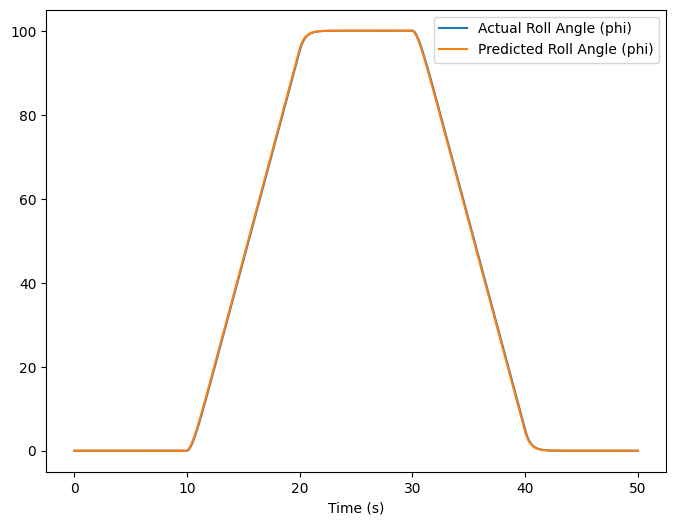

In [10]:
# now let's compare the predicted roll angle with the actual roll angle
y = [phi, phi_dot]

phi_predicted = LinearRegression(y, t, Jx, c, t, taux_vals)
plt.figure(figsize=(8, 6))
plt.plot(t, phi, label="Actual Roll Angle (phi)")
plt.plot(t, phi_predicted, label="Predicted Roll Angle (phi)")
plt.legend()
plt.xlabel("Time (s)")
plt.show()
